# Disco-GAN

This is an attempt to re-implement the paper Disco-GAN

Paper: https://arxiv.org/pdf/1703.05192.pdf

Other Resources: 
* https://github.com/SKTBrain/DiscoGAN

In [1]:
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
img_shape = (64, 64, 3)
num_images = -1 #1000
batch_size = 64

In [3]:
def load_data(files):
    images = tf.io.decode_png(tf.io.read_file(files), channels = img_shape[-1])
    images = tf.cast(images, tf.float32)
    images = (images/127.5) - 1
    images = tf.image.resize(images, [img_shape[0], img_shape[1]], tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return images

In [4]:
def load_files(path, num_images = num_images, batch_size = batch_size):
    files = glob(path)[:num_images]
    return tf.data.Dataset.list_files(files).map(load_data).shuffle(len(files)).batch(batch_size)
DIR = 'E:\Image Datasets\Horses_2_Zebras'
dataset_a = load_files(DIR + '\\Train\\Horse\\*.jpg')
dataset_b = load_files(DIR  + '\\Train\\Zebra\\*.jpg')

In [5]:
class GAN(object):
    def __init__(self, img_shape = img_shape, more_layers = False):
        self.img_shape = img_shape
        self.more_layers = more_layers
        
        self.generator_a2b = self.__generator('generator_a2b')
        self.generator_b2a = self.__generator('generator_b2a')
        self.discriminator_a = self.__discriminator('discriminator_a')
        self.discriminator_b = self.__discriminator('discriminator_b')
        
    def __generator(self, model_name = None):
        inp = tf.keras.layers.Input(shape = self.img_shape, dtype = tf.float32, 
                            name = f'generator_{None if model_name is None else model_name[-3:]}_input_{self.img_shape}')
        
        # Encoder
        x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(inp)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        if self.more_layers:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        if self.more_layers:
            x = tf.keras.layers.Conv2D(filters = 256, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
            x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
            
            
        # Decoder
        if self.more_layers:
            x = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
            x = tf.keras.layers.ReLU()(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        if self.more_layers:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.Activation('tanh')(x)
        
        return tf.keras.models.Model(inp, x, name = 'generator' if model_name is None else model_name)
    
    def __discriminator(self, model_name = None):
        inp = tf.keras.layers.Input(shape = self.img_shape, dtype = tf.float32, 
                            name = f'discriminator_{None if model_name is None else model_name[-1]}_input_{self.img_shape}')
        
        x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(inp)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
        if self.more_layers:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        if self.more_layers:
            x = tf.keras.layers.Conv2D(filters = 256, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(x)
            x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
            
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units = 1)(x)
        #x = tf.keras.layers.Activation('sigmoid')(x)
            
        return tf.keras.models.Model(inp, x, name = 'discriminator' if model_name is None else model_name)

In [8]:
class Losses(object):
    def __init__(self):
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
    
    def reconstruction_loss(self, real_img, re_gen_img):
        return tf.math.reduce_mean(tf.math.square(real_img - re_gen_img))
    
    def generator_bce_loss(self, disc_gen_out):
        return self.bce(tf.ones_like(disc_gen_out), disc_gen_out)
    
    def discriminator_bce_loss(self, disc_real_out, disc_gen_out):
        real_loss = self.bce(tf.ones_like(disc_real_out), disc_real_out)
        gen_loss = self.bce(tf.zeros_like(disc_gen_out), disc_gen_out)
        return real_loss + gen_loss

In [9]:
class Trainer(object):
    def __init__(self, gan_class, img_shape = img_shape, learning_rate = 2e-4):
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.5, beta_2 = 0.999)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.5, beta_2 = 0.999)
        
        if callable(gan_class):
            self.gan = self.gan_class(img_shape)
        else:
            self.gan = gan_class
            
        self.generator_a2b = self.gan.generator_a2b
        self.generator_b2a = self.gan.generator_b2a
        self.discriminator_a = self.gan.discriminator_a
        self.discriminator_b = self.gan.discriminator_b
            
        self.gan_loss = Losses()
        self.reconstruction_loss = self.gan_loss.reconstruction_loss
        self.generator_bce_loss = self.gan_loss.generator_bce_loss
        self.discriminator_bce_loss = self.gan_loss.discriminator_bce_loss
        
    def total_reconstruction_loss(self, real_a, real_b, re_gen_img_a, re_gen_img_b):
        const_a = self.reconstruction_loss(real_a, re_gen_img_a)
        const_b = self.reconstruction_loss(real_b, re_gen_img_b)
        return const_a + const_b
        
    def generator_loss(self, disc_gen_out_a, disc_gen_out_b, real_a, real_b, re_gen_img_a, re_gen_img_b):
        gen_loss_a2b = self.generator_bce_loss(disc_gen_out_b)
        gen_loss_b2a = self.generator_bce_loss(disc_gen_out_a)
        total_recon_loss = self.total_reconstruction_loss(real_a, real_b, re_gen_img_a, re_gen_img_b)
        return gen_loss_a2b + gen_loss_b2a + total_recon_loss
    
    def discriminator_loss(self, disc_real_out, disc_gen_out):
        return self.discriminator_bce_loss(disc_real_out, disc_gen_out)
        
    def train(self, data_a, data_b, epochs = 1):
        gen_losses, disc_losses = [], []
        for e in range(epochs):
            print(f'Epoch: {e} Starts')
            for img_a, img_b in zip(data_a, data_b):
                tot_gen_loss, disc_loss = self.train_step(img_a, img_b)
                print('.', end = '')
                
            gen_losses.append(tot_gen_loss)
            disc_losses.append(disc_loss)
            print(f'\nTotal Generator Loss: {tot_gen_loss} \t Discriminator Loss: {disc_loss}')
            print(f'Epoch: {e} Ends\n')
            
        return gen_losses, disc_losses
    
    @tf.function
    def train_step(self, img_a, img_b):
        
        with tf.GradientTape(persistent = True) as tape:
            gen_out_b = self.generator_a2b(img_a, training = True)
            gen_out_a = self.generator_b2a(img_b, training = True)
            
            re_gen_out_a = self.generator_b2a(gen_out_b, training = True)
            re_gen_out_b = self.generator_a2b(gen_out_a, training = True)
            
            disc_real_out_a = self.discriminator_a(img_a, training = True)
            disc_gen_out_a = self.discriminator_a(gen_out_a, training = True)
            disc_real_out_b = self.discriminator_b(img_b, training = True)
            disc_gen_out_b = self.discriminator_b(gen_out_b, training = True)
            
            tot_gen_loss = self.generator_loss(disc_gen_out_a, disc_gen_out_b, img_a, img_b, re_gen_out_a, re_gen_out_b)
            disc_loss = self.discriminator_loss(disc_real_out_a, disc_gen_out_a) + self.discriminator_loss(disc_real_out_b, 
                                                                                                          disc_gen_out_b)
            
        gen_params = self.generator_a2b.trainable_variables + self.generator_b2a.trainable_variables
        gen_grads = tape.gradient(tot_gen_loss, gen_params)
        self.generator_optimizer.apply_gradients(zip(gen_grads, gen_params))
        
        disc_params = self.discriminator_a.trainable_variables + self.discriminator_b.trainable_variables
        disc_grads = tape.gradient(disc_loss, disc_params)
        self.discriminator_optimizer.apply_gradients(zip(disc_grads, disc_params))
        
        return tot_gen_loss, disc_loss

In [10]:
trainer = Trainer(GAN(more_layers = False))

In [93]:
training_losses = trainer.train(dataset_a, dataset_b, epochs = 1)

Epoch: 0 Starts
.................
Total Generator Loss: 2.7582216262817383 	 Discriminator Loss: 2.235574245452881
Epoch: 0 Ends



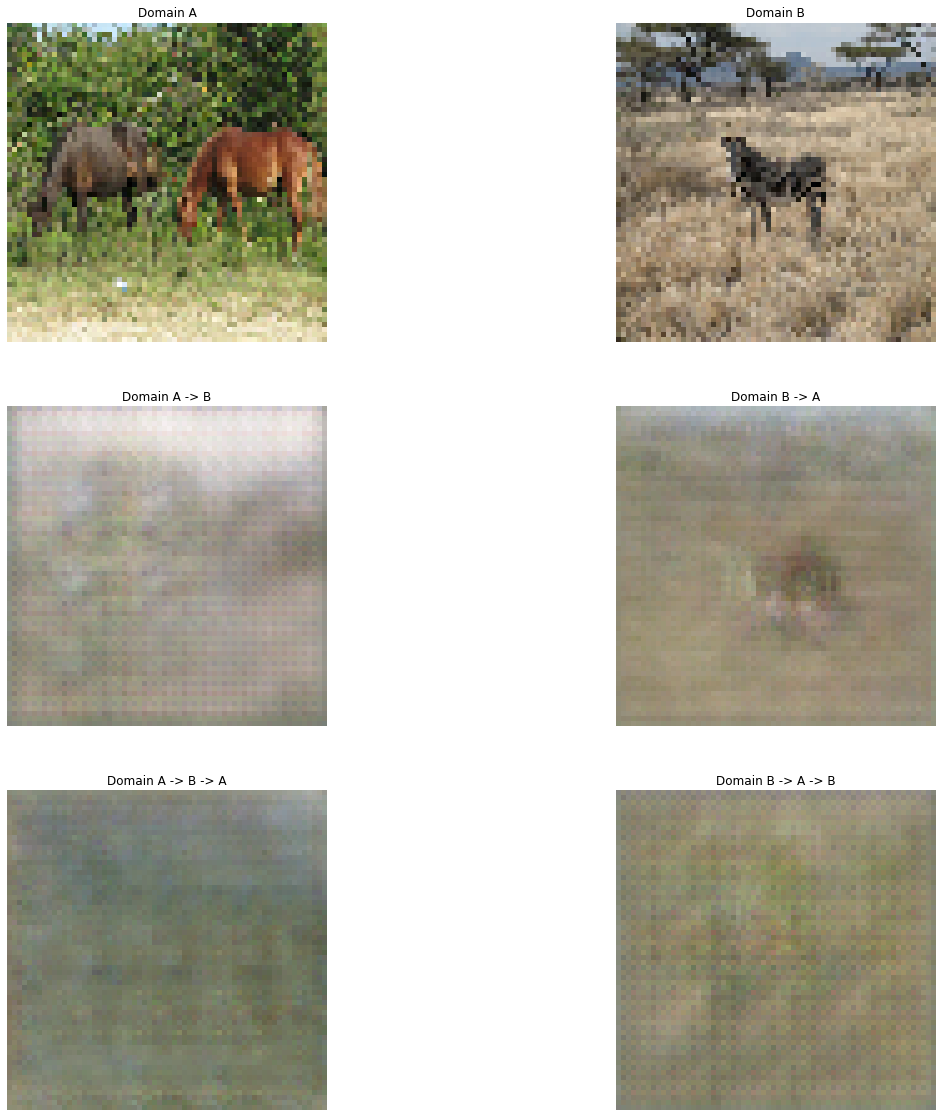

In [103]:
sample_img_a = next(iter(dataset_a))
sample_img_b = next(iter(dataset_b))

plt.figure(figsize = (20, 20))

plt.subplot(321)
plt.imshow(((sample_img_a+1)*127.5).numpy().astype('uint8')[0])
plt.title('Domain A')
plt.axis('off')

plt.subplot(322)
plt.imshow(((sample_img_b+1)*127.5).numpy().astype('uint8')[0])
plt.title('Domain B')
plt.axis('off')

plt.subplot(323)
plt.imshow(((trainer.generator_a2b(sample_img_a).numpy()+1)*127.5).astype('uint8')[0])
plt.title('Domain A -> B')
plt.axis('off')

plt.subplot(324)
plt.imshow(((trainer.generator_b2a(sample_img_b).numpy()+1)*127.5).astype('uint8')[0])
plt.title('Domain B -> A')
plt.axis('off')

plt.subplot(325)
plt.imshow(((trainer.generator_b2a(trainer.generator_a2b(sample_img_a)).numpy()+1)*127.5).astype('uint8')[0])
plt.title('Domain A -> B -> A')
plt.axis('off')

plt.subplot(326)
plt.imshow(((trainer.generator_a2b(trainer.generator_b2a(sample_img_b)).numpy()+1)*127.5).astype('uint8')[0])
plt.title('Domain B -> A -> B')
plt.axis('off')

plt.show()

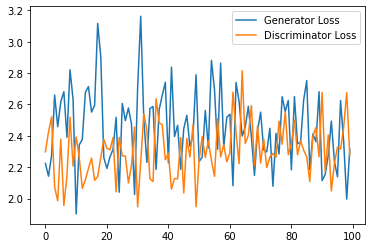

In [70]:
plt.plot(training_losses[0], label ='Generator Loss')
plt.plot(training_losses[1], label = 'Discriminator Loss') 
plt.legend()
plt.show()